# Tabu Search for 3-SAT

`2022, February 2nd, Jaroslav Langer`

## Abstract

SAT (Boolean satisfiability problem) is an NP-complete problem without one efficient solution.
In this project I experimented with solving 3-SAT by using Tabu Search.

Results were measured on 10 different sets with total of 340 instances.
Based on the measurement results I consider Tabu Search an viable
approach for 3-SAT problem.

## 3-SAT

Is a version of [boolean satisfiability problem](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem) where every clause has up to three variables. In this case, all clauses of all instances had exactly 3 variables.

## Tabu Search

[Tabu search](https://en.wikipedia.org/wiki/Tabu_search) is a local search heuristic. The main idea is that state which was recently visited is prohibited (taboo) from being visited again. This feature pushes the search to a less atractive states as the better ones became prohibited one by one.

### Implementation

Let's demonstrate the implementation by a simple pseudo-code:


```python
t = 0
while True:
    for neighbor in yield_neighbor(next_state):
        if t == max_iteration:
            return best_value, best_state
        t += 1

        if should_reinitialize():
            reinitialize()
            break
            
        if not_tabu(neighbor):
            neighbor_value = value_function(neighbor)
            if neighbor_value >= next_value:
                next_value = neighbor_value
                next_state = neighbor

    add_tabu(next_state)
    if next_value > best_value:
        best_value, best_state = (next_value, next_state)
    next_value = initial_value
```

**max_iteration**

I chose to increment the time `t` everytime when `value_function` is called.
Later I will discuss that the number of `value_function` calls in fact reflects the overall complexity.

Also I chose to `yield` the values as a side product of the computation of the biggest `max_iteration`.
In other words when the `max_iterations` would be `['n', 'nlogn', 'nn', 'nnn']`, the solver computes the `max_iteration = 'nnn'` and at times `'n'`, `'nlogn'` and `'nn'` the best values and measured time are yielded.

**Tabu**

There are multiple ways to store the tabu states. I chose to start with simple full-state tabus and to transit to something more sophisticated (such as attributes tabu) when needed. To my own surprise, storing all visited states as python `tuple`s was not actually problem at all.

The tabu `tuple`s were stored as keys in a `tabu` dictionary, where value is a time when the state will break the tabu.

In case all the states would be tabu, the time would increment until either `tabu_tenure` would expire for some state, or until the `max_iteration`.

**Neighbors**

First I implemented the obvious solution: try every neighbor for every state.

Then I implmented a second approach, where the neighbors are sampled.
I chose sample of size $log(n)$.
There is no point in fixed ordering, because if the subset would be smaller than the number of neighbors, then some neighbors would be unreachable (e.g. last variable would never be swapped).
I came up with two ways to sample the neighbors.
First is to sample them uniformly i.e. every neighbor has the same probability to be chosen.
Second way is to draw the probabilities from their `weights` (this approach is labeled as `logn_weighted`).

**Reinitializations**

During the 4th homework of this course I discovered that some reinitializations may release the state from a wider plateaus.
Here the reinitializations are implemented in a way, you choose a function of $n$ i.e. how many times the state should be reinitialzed. It enables all posibilities from $0$ `reinits` to `max_iteration` reinitializations.
It seems the best approach might be somewhere in between.

### Hardware and Measurement Details

CPU: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz

RAM: 8GB

The time elapsed was measured using Python's  [time.process_time()](https://docs.python.org/3/library/time.html#time.process_time).

The scripts were run from terminal, however I usually worked on the pc while the computation was running (sad). Also python runs as a single thread and i did not use threading at all. 

### Profiling

Before we jump to the Whit-box analysis I would just to add validity to some earlier statements.
For the whole time I was using library `cProfile` that measures times and durations for every function that was called during an execution.
For the simple algorithm (without advanced `get_neighber`, `reinits` etc.) the by far biggest portion of time spent was by the `value_function` calls.
The `value_function` based on assigned variables, weights and clauses returns the objective value.
Example profiler output: Look at the third line `value_function` was called 1.7 million times, took 1506 out of 1866 seconds. 
```
  ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      436    0.103    0.000 1866.681    4.281 src/solver.py:99(tabu)
     2180  253.128    0.116 1866.435    0.856 src/solver.py:20(tabu_core)
 17744647  717.329    0.000 1506.484    0.000 src/validator.py:38(compute_satisfied_x_variables_x_weights)
```
It is also the main reason why I kept storing the tabus as is. The time and space requirements are fine in comparison to other code sections.

## White-box Analysis

Or configuration/parameters analysis. Let's explore different configurations and their relation to `time` and `relative_error`.

Choosing the best parameters may be missleading when the parameter values are tested in isolation (when there are fixed baseline and one parameters chagnes at a time).

In order to prevent this I tested a cartesian product of all configurations.
Based on this decision, I believe, the final parameters will actually be the best out of the tested ones.

Downside of this approach is the growth pace of required tests for configurations.
So I naturally used some quick-tests / educated guesses to limit the number of configurations needed to be tested.

### Maximum Iteration

Before I had done any `max_iteration` guesses I had first searched for them on the internet.
I found there is a [numerical upper bound of $O^∗(1.30331^n)$ for 3SAT](https://cstheory.stackexchange.com/questions/1060/best-upper-bounds-on-sat).

And as I tested variable sizes of 20 and 50, that is $$1.30331^{20}=199.965, \quad 1.30331^{50}=565439.8$$ I substituted theses with $n^3$ i.e.
$$20^3 = 8000, \quad 50^3=125000$$ the orders are roughly the same, and the relatively higher number for the 20 variables I found handy.

This is why I chosed the `max_iteration` to be $n^3$ as I should be capable of obtaining a fairly good results below the numerical upper bound.

Ok, enough theory, let's look at the data!

In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from api import frame, index_20, index_50, blackbox, bb20, bb50

def boxplots(frame, index=None, i20=index_20, i50=index_50, **kwargs):
    if index is None:
        index = frame.index
    fig, axes = plt.subplots(2, 1, figsize=(10,6))
    sns.boxplot(**kwargs, data=frame.iloc[index.intersection(i20)],
                ax=axes[0])
    sns.boxplot(**kwargs, data=frame.iloc[index.intersection(i50)],
                ax=axes[1])
    
def pairplot(frame):
    g = sns.PairGrid(frame,
                     x_vars=['time', 'relative_error'],
                     y_vars=['max_iteration', 'neighbors', 'tabu_tenure', 'reinits'],
                     hue='group', height=3.5)
    g.map(sns.stripplot, jitter=1.2, size=3, dodge=True)
    g.add_legend()

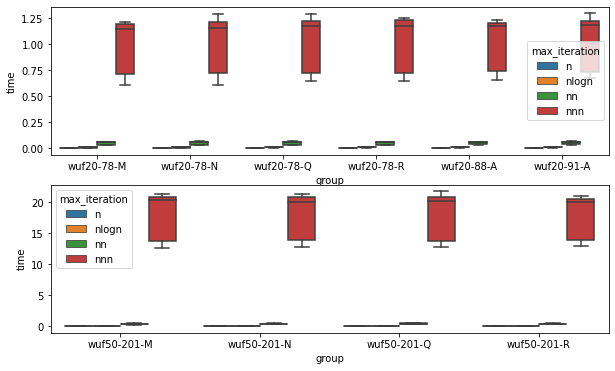

In [2]:
boxplots(frame, x='group', y='time', hue='max_iteration')

Unsurprisingly for exponentially chosen sequence `n -> nn -> nnn` the times grow exponentially.

What about the `relative_error`?

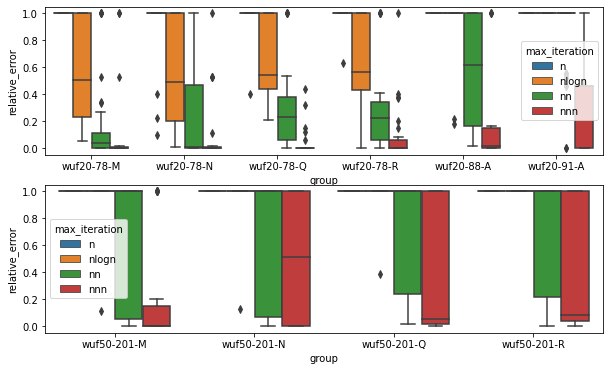

In [3]:
boxplots(frame, x='group', y='relative_error', hue='max_iteration')

In [4]:
d = frame.groupby(['group', 'max_iteration']).mean()['relative_error']
print('nnn mean relative_error for wuf20-91-A is {:%}'.format(
      d[('wuf20-91-A','nnn')]))
print('nnn mean relative_error for wuf50-201-N is {:%}'.format(
      d[('wuf50-201-N','nnn')]))

nnn mean relative_error for wuf20-91-A is 33.229491%
nnn mean relative_error for wuf50-201-N is 50.184302%


Ok, these charts are not super-readable, however some information are definitly there.
1) All the sets 20-??-M...R are obviously easier than the "A" one. It is clear from the fact that the `nlogn` works with M-R (somehow) but does not with the "A".
2) The difference is vissible between all of `max_iteration` settings.
    - `n` is obviously not enough as the error is 1 every single time.
    - `nlogn` works a little with small and simple instances.
    - `nn` works fine for the simple M-R and small (20 variable) instances,
        however for the hard A, and bigger 50 variable instances it does not work well (look at the mean value - the line is simply not there).
    - finally the `nnn` works quite nice, however the 50% error for the 50-201-N is definitely not a winning lottery. We will see what we can do with it.
    
How many formulas were not satisfied at all by the tabu search?

In [6]:
nnn = frame[frame.max_iteration == 'nnn']

ratio = (nnn.relative_error != 1).sum() / nnn.shape[0]
print(f'Ratio of satisfied formula: {ratio:%}')

Ratio of satisfied formula: 81.944444%


Ok, so there are about 20% of formulas that the Tabu search was not able to solve even in `nnn` iterations.

Let's look at the same chart, when the unsatisfied instances are omitted.

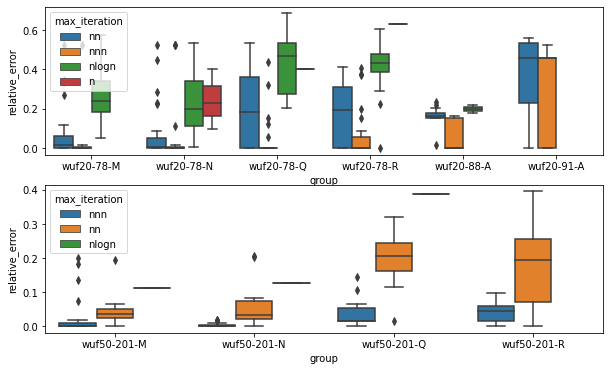

In [7]:
boxplots(frame, frame[frame.relative_error != 1].index,
         x='group', y='relative_error', hue='max_iteration')

I am sorry for the super confusing change of colours. Besides that the solutions are usually quite ok. It looks like the biggest challange will be to find at least one solution.

In conclusion, when talking simply about `max_iteration` the more is obviously better, the `nnn` looks like a promising candidate if the other configurations will be tuned as well.

### Parameters and Their Relations

Following charts are not intended to give you an exact numbers (they are below), these charts are here to show you (or to not show you) the relations and trends among the parameter values.

First example, if you look at the first row - first column (`max_iteration`, `time`) the exponential growh is visible. However the `nnn` has two separate areas, one around 0.75 seconds and second about 1.25 seconds. The reason for this is actually the second row.
`neighbors`, if searched extensively, have very simple imlementaion (one for-loop), on the other hand both shorted (sampled) version must sample the neighbors for every visited state which increases the time incredibly. More about this in the the discussion part.

Let's look at the rest of the relations.

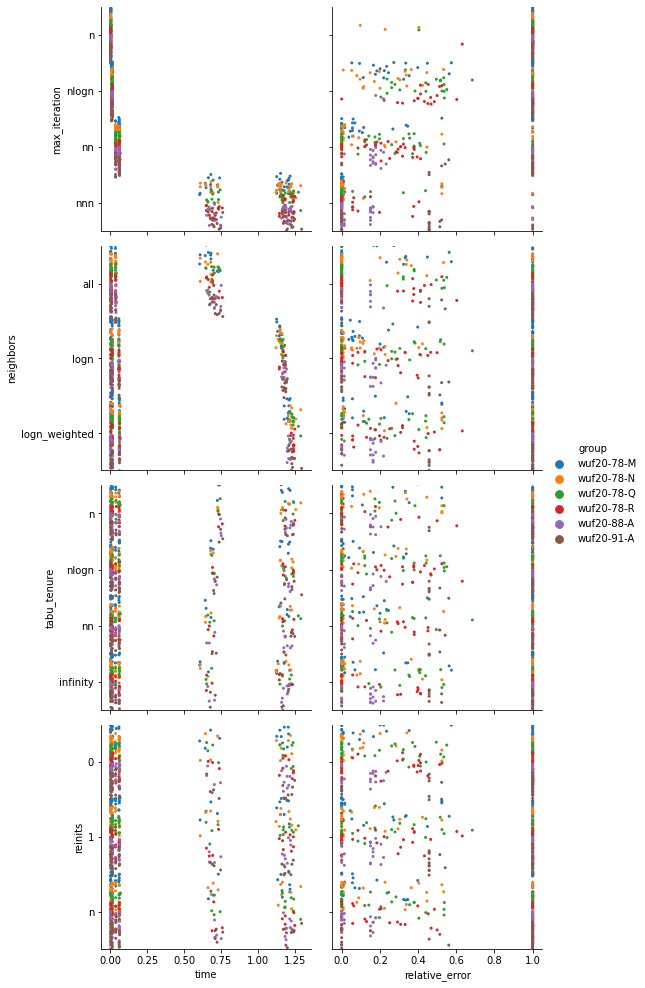

In [8]:
pairplot(frame.iloc[index_20])

Besides the time consumption there are not much left. The relative error looks the same for all the charts except the `max_iteration` which sounds like that the impacts of other parameters are much smaller.

Fortunately the chart for the bigger instances tells us one more thing...

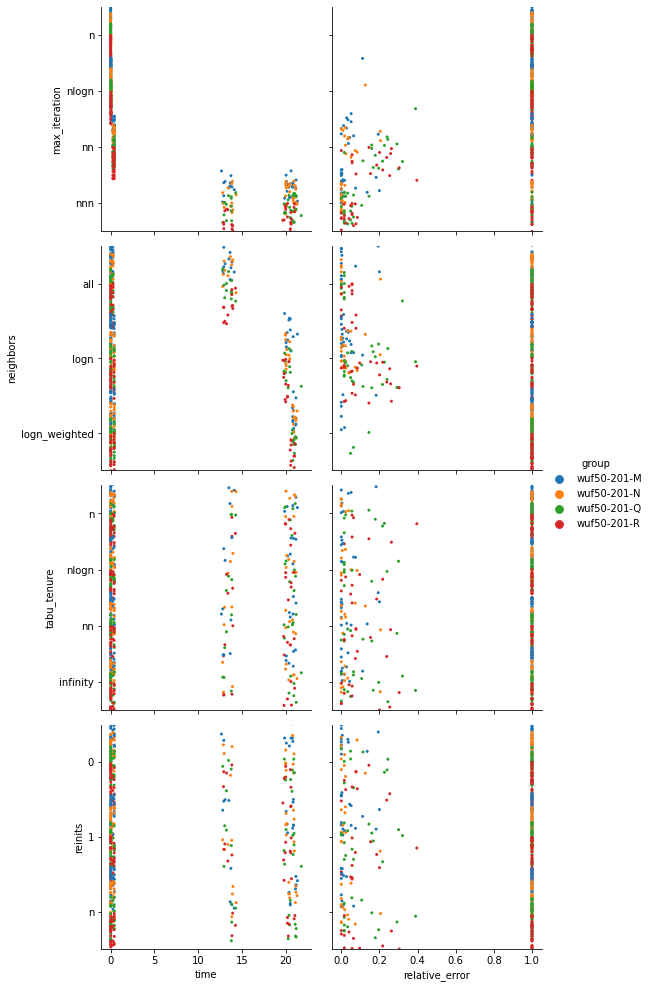

In [9]:
pairplot(frame.iloc[index_50])

In the `neighbors` in the `relative_error` chart, it is visible, that unintuitively the method `logn_weighted`, despite it is the most time consuming one, it does not work at all.
On the other hand the `logn` variant outperforms the plain `all` option.
It might mean, it is better to move more than less. In other words when there are 20 variables and you tries all of them, after 20 steps you are one variable-change faraway.
In contrast if you sample `logn` ($ceil(log_2(20))=5$) neighbors, after 20 steps you may be 4 variabale-change faraway.

### Best Parameters in Numbers

Now let's look at the actual numbers and let's choose the best parameters.
Values in the tables are the means of all the sets.

In [10]:
for column in ['max_iteration', 'neighbors', 'tabu_tenure', 'reinits']:
    display(frame.groupby([column]).mean()[['time', 'relative_error']])

,time,relative_error
max_iteration,,
n,0.004671,0.991009
nlogn,0.023702,0.845320
nn,0.177216,0.514829
nnn,7.894337,0.228906


,time,relative_error
neighbors,,
all,1.488299,0.641275
logn,2.253164,0.518591
logn_weighted,2.333482,0.775182


,time,relative_error
tabu_tenure,,
infinity,2.015297,0.619588
n,2.043097,0.678422
nlogn,2.027578,0.658674
nn,2.013954,0.623379


,time,relative_error
reinits,,
0,2.005990,0.658314
1,2.011038,0.640580
n,2.057917,0.636154


Two remaining remarks. 

**Tabu Tenure**

Talking about the `tabu_tenure` the impact is not great.
It supprts the main idea, that once visited state should not be visited again.

This finding is not completely obvious, when I was thinking about it in advance, I thought It might be useful to sometimes go back to already visited state.
Imagine a valley in a canyon with a single state pass-through. In case, you would fall there, you would perhaps want to go left for some time, and then go back through the same spot to visited the other side.

However this idea is simply not supported by the data. In such case you would probably by-pass the visited state by a slightely worse state (e.g. one to the right of it), so my case probably does not hold.

**Reinitializations**

As I said, the impact of `tabu_tenure` is not great, well, the impact of `reinits` is even smaller.

Again, it supports the thesis that it is better to move more, than less. However the impact is so small, that it is actually surprising to me. It looks like it does not matter much, if you reinitialize your state in the middle of your journey, or if you do it every n-th step or not at all.

I take this as a lesson, that in order for the reinitializations to be more meaningful (impactful) they need to happen on demand (when really needed). Unfortunately I did not come up with a simple solution to recognize when reinitializtion is needed. The (stupid) sampling of neighbors puts the time consumtion to the moon, so having some more advanced mechanism for plateau recongnition was out of my imagination.

I see the `n` reinitialization as a insurance against bad start and wierd transition space. Of course when I talk about n-reinitializations I mean for the `nnn` `max_iteration`.

## Black Box Evaluation

Ok, let's explore the heuristic with winning parameters from the white-box phase.

| Parameter     | Value   |
| ---           | ---     |
| max_iteration | n^3     |
| neighbors     | log2(n) |
| tabu_tenure   | inf     |
| reinits       | n       |


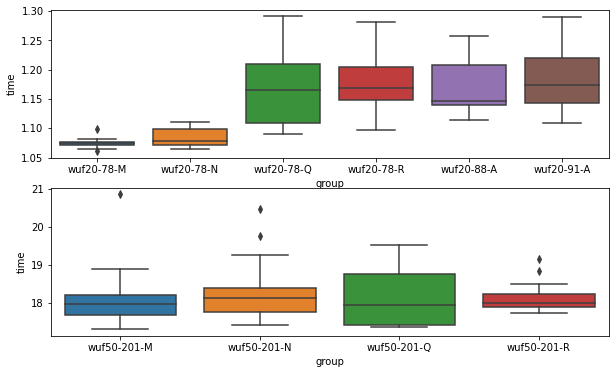

In [11]:
boxplots(blackbox, blackbox[blackbox.max_iteration == 'nnn'].index,
         i20=bb20, i50=bb50, x='group', y='time')

Times taken by the M and N instaces are significantely lower than the times of Q-A instances.
I have an idea why is it like this, but I was not able to prove it.

I will say it anyway: There is a slightely bigger overhead with visiting new states ("moving more, than less"), than going around the well-known places.
If the state is mostly new, then there is no tabu value in the dictionary which leads to exception and its handling (faster than `dict.get` based on the `cProfile`). Also when the state is not tabu, then, and this is what actually matters, the `value_function` is called for the new state. It means more new states in neighbors means more `value_function` calls and as it was shown earlier is the most costly thing.

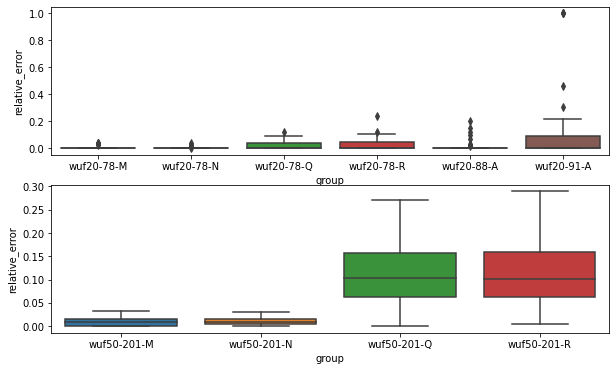

In [12]:
boxplots(blackbox, blackbox[blackbox.max_iteration == 'nnn'].index,
         i20=bb20, i50=bb50, x='group', y='relative_error')

In my opinion it looks good. Reason why Q-R instances are worse than M,N was written in the sets description, they are made to be harder.

In [13]:
i_nnn = blackbox[blackbox.max_iteration == 'nnn'].index

pd.concat([
    blackbox.iloc[bb20.intersection(i_nnn)][['time', 'relative_error']].describe(),
    blackbox.iloc[bb50.intersection(i_nnn)][['time', 'relative_error']].describe(),
], axis=1, keys=['20', '50'])

20                         50               
             time relative_error        time relative_error
count  204.000000     204.000000  136.000000     136.000000
mean     1.142749       0.035785   18.115261       0.060585
std      0.060713       0.129752    0.593828       0.070729
min      1.061133       0.000000   17.310845       0.000000
25%      1.081940       0.000000   17.784496       0.008360
50%      1.138906       0.000000   18.020496       0.021379
75%      1.181761       0.020705   18.314268       0.101162
max      1.291047       1.000000   20.851077       0.289665

Relative error lower than 10.1% in 75% of cases is what I can live with. 

In [14]:
nnn = blackbox[blackbox.max_iteration == 'nnn']
ratio = (nnn.relative_error != 1).sum() / nnn.shape[0]
print(f'Ratio of satisfied formula: {ratio:%}')

Ratio of satisfied formula: 99.117647%


Nice.

## Discussion

**Python**

As I chose Python I subsequentely made multiple decision that were heavily influenced by it.
I know runnin python code is slow, so I tried to write it as little as possible and delegate it to lower libraries mostly numpy.
In different language I would probably tried to to more "little tricks" such as not to copy the `assignment_vector` every time the state is better than the old one, I would just swapped the values accordingly, however in Python things like this have negative net effect so I tried then only few times and failed everytime.

I tried to use as much generators (do not store value unless you want to store it) as possible and still the sampled `get_neighbors` had massive performance dent.

I personally can not write more efficient python, so in order to make it faster, I would probably pay someone to write it in c++ efficiently.

**Better than 10% Relative Error**

There are a few obious ways to try. The first one I would go for would be to increase the `max_iteration`. It is a stupid thing but I think it is the lowest hanging fruit here.

I have one more thing I wanted to do until I had forgotten about it and until it was too late.
And that is a better `value` comparison.
The `value` comparison is actually comparison of `tuple(total_value, satisfied_clauses)`, so if one state has higher `total_value`, it wins, however if the `total_value`s are equal e.g. 0, then the state with higher number of satisfied clauses wins.
I had an improvement in mind to add a third part `tuple(total_value, satisfied_clauses, weights_sum)` i.e. if two states would have the same `total_value` (0) and same number of satisfied clauses let's say 5, the one with the higher "potential value" would be prefferered.
I have not implemented this, first because the parametrization could have effected the performace, but worse then I forgot about it until writing this section.

**Bigger Instances**

The `cProfiler` speaks load and clear, for the matrices (20,3) and (50,3) it finishes $11243.648$ `value_function` calls per second, and for the biggest instance (100,3) it performes $12738.964$ `value_function` calls per second, so the additional growth is not that bad.

## Conclusion

To sum up, the Tabu search was implemented and is parametrized with functions, so it is easy to test another configuration.
The biggest impact on both the `time` and the `relative_error` has unsurprisingly the `max_iteration` parameter.
To my own biggest surprise the `tabu_tenure` does not show a significant effect.
Sampling the `neighbors` helps, but you need to consider the time costs.
Reinitializations (`reinits`) also helps, but in orders of percents, more sophisticated approach would be an interesting goal to follow. This project persuaded me that Tabu search, despite its simple idea, is a powerful tool and in my opinion nicely suitable for 3-SAT problem.